Cell data type: <class 'numpy.ndarray'>
Image data shape: (1080, 1920, 4)
Data has more than 2 dimensions. Reducing to 2D.


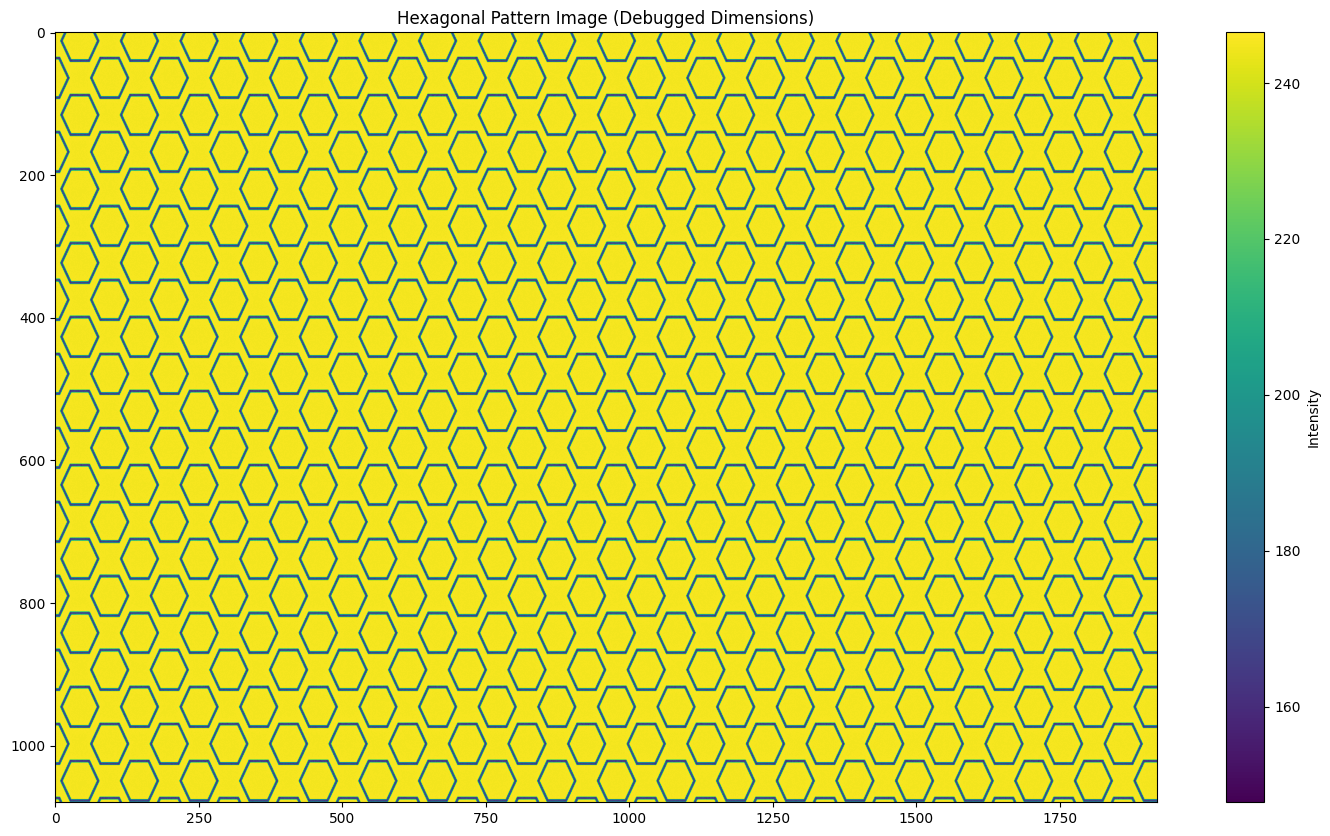

In [18]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from preparation import load_pickle_data

# Path to the pickle file
file_path = 'Images/hex_img_data.pkl'

def custom_load_pickle(file_path):
    """
    Custom wrapper to load the pickle file and handle it as-is.
    """
    try:
        # Load the pickle file
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Ensure it's a DataFrame
        if isinstance(data, pd.DataFrame):
            return data
        else:
            raise ValueError("Loaded data is not a DataFrame.")
    except Exception as e:
        print(f"Error loading pickle data: {e}")
        return pd.DataFrame()  # Return empty DataFrame on failure

try:
    # Load the data
    raw_data = custom_load_pickle(file_path)

    if not raw_data.empty:
        # Extract the single cell
        cell_data = raw_data.iloc[0, 0]  # Access the single cell
        print(f"Cell data type: {type(cell_data)}")

        # If the cell contains an array-like structure, reshape it
        if isinstance(cell_data, np.ndarray):
            image_data = cell_data
        else:
            image_data = np.array(cell_data)

        # Debugging the shape
        print(f"Image data shape: {image_data.shape}")

        # Validate the shape
        if len(image_data.shape) > 2:
            # If more than 2D, reduce dimensions (e.g., take the first layer or average channels)
            print("Data has more than 2 dimensions. Reducing to 2D.")
            image_data = np.mean(image_data, axis=-1)  # Average over the last axis

        if len(image_data.shape) == 1:
            # If 1D, assume square and reshape (if possible)
            side_length = int(np.sqrt(len(image_data)))
            image_data = image_data.reshape((side_length, side_length))

        # Get dimensions for correct aspect ratio
        height, width = image_data.shape
        aspect_ratio = width / height

        # Display the hexagonal image
        plt.figure(figsize=(10 * aspect_ratio, 10))
        plt.imshow(image_data, cmap='viridis', aspect='auto')
        plt.title("Hexagonal Pattern Image (Debugged Dimensions)")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print("The loaded data is empty.")
except Exception as e:
    print(f"An error occurred: {e}")
